In [ ]:
!pip3 install wordcloud
!pip3 install transformers xgboost torch scikit-learn pandas tqdm hf_xet iterative-stratification


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 81.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [ ]:
#  Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from transformers import AutoTokenizer, AutoModel
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.optim import AdamW
import re
from ast import literal_eval
from tqdm import tqdm


In [ ]:
# Загрузка данных
df = pd.read_csv('data copy.csv')
df

,annotation_id,annotator,comment,created_at,id,lead_time,rating,sentiment,updated_at,Вопрос решен,Нравится качество выполнения заявки,Нравится качество работы сотрудников,Нравится скорость отработки заявок,Понравилось выполнение заявки,Негативное
0,1.0,1.0,спасибо,2025-05-08T13:43:58.670350Z,2945792.0,229.477,5.0,"{""choices"": [""Понравилось выполнение заявки"", ...",2025-05-09T13:12:44.065760Z,1.0,0.0,0.0,0.0,1.0,0
1,2.0,1.0,спасибо!,2025-05-08T13:44:06.887197Z,3234340.0,7.589,5.0,"{""choices"": [""Понравилось выполнение заявки""]}",2025-05-09T10:57:27.209739Z,0.0,0.0,0.0,0.0,1.0,1
2,3.0,1.0,Отлично,2025-05-08T13:44:17.129499Z,3380332.0,16.082,5.0,"{""choices"": [""Понравилось выполнение заявки"", ...",2025-05-09T10:57:17.714712Z,1.0,0.0,0.0,0.0,1.0,0
3,4.0,1.0,Благодарю за оперативное решение проблемы !,2025-05-08T13:45:15.409884Z,3381812.0,56.595,5.0,Нравится скорость отработки заявок,2025-05-08T13:45:15.410883Z,0.0,0.0,0.0,0.0,0.0,0
4,5.0,1.0,Прекрасный специалист! Побольше таких,2025-05-08T13:45:22.315316Z,3461991.0,5.910,5.0,Нравится качество работы сотрудников,2025-05-08T13:45:22.315316Z,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2367,671.0,1.0,"долго, но приятно",2025-05-10T22:18:38.787028Z,3507812.0,2.096,5.0,Вопрос решен,2025-05-10T22:18:38.787028Z,0.0,0.0,0.0,0.0,0.0,0
2368,672.0,1.0,16.03.2024 г ребята установили кондиционер. ра...,2025-05-10T22:18:47.955163Z,3478532.0,6.796,5.0,"{""choices"": [""Нравится скорость отработки заяв...",2025-05-10T22:18:47.955163Z,1.0,1.0,1.0,1.0,1.0,0
2369,673.0,1.0,два дня мусоропровод. сегодня с утра тоже,2025-05-10T22:18:57.318493Z,3296403.0,7.427,5.0,Негативное,2025-05-10T22:18:57.318493Z,0.0,0.0,0.0,0.0,0.0,0
2370,674.0,1.0,отрегулировать дверь замки . для должного откр...,2025-05-10T22:19:02.362933Z,3165822.0,3.135,5.0,Негативное,2025-05-10T22:19:02.362933Z,0.0,0.0,0.0,0.0,0.0,0


In [ ]:
# Очистка данных
df = df.dropna(subset=['sentiment'])

In [21]:
df.isna().sum()

,0
annotation_id,0
annotator,0
comment,0
created_at,0
id,0
lead_time,0
rating,0
sentiment,0
updated_at,0
Вопрос решен,0


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2372 entries, 0 to 2371
Data columns (total 15 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   annotation_id                         2372 non-null   float64
 1   annotator                             2372 non-null   float64
 2   comment                               2372 non-null   object 
 3   created_at                            2372 non-null   object 
 4   id                                    2372 non-null   float64
 5   lead_time                             2372 non-null   float64
 6   rating                                2372 non-null   float64
 7   sentiment                             2372 non-null   object 
 8   updated_at                            2372 non-null   object 
 9   Вопрос решен                          2372 non-null   float64
 10  Нравится качество выполнения заявки   2372 non-null   float64
 11  Нравится качество

In [23]:
# 📦 Импорт необходимых библиотек
import pandas as pd
import json
from ast import literal_eval

all_labels = [
    "Вопрос решен",
    "Нравится качество выполнения заявки",
    "Нравится качество работы сотрудников",
    "Нравится скорость отработки заявок",
    "Понравилось выполнение заявки",
    "Отрицательное"
]

for label in all_labels:
    df[label] = 0

def process_sentiment(row):
    sentiment = row['sentiment']

    try:
        if isinstance(sentiment, str):
            try:
                data = literal_eval(sentiment)
                if isinstance(data, dict) and 'choices' in data:
                    labels = data['choices']
                else:
                    labels = [str(data)] if data else []
            except:
                labels = [sentiment]
        elif isinstance(sentiment, dict):
            labels = sentiment.get('choices', [])
        else:
            labels = [str(sentiment)]
    except:
        labels = [str(sentiment)]

    for label in labels:
        if label in all_labels:
            row[label] = 1
        else:
            for existing_label in all_labels:
                if label.lower() == existing_label.lower():
                    row[existing_label] = 1
                    break

    return row

df = df.apply(process_sentiment, axis=1)
df


,annotation_id,annotator,comment,created_at,id,lead_time,rating,sentiment,updated_at,Вопрос решен,Нравится качество выполнения заявки,Нравится качество работы сотрудников,Нравится скорость отработки заявок,Понравилось выполнение заявки,Негативное,Отрицательное
0,1.0,1.0,спасибо,2025-05-08T13:43:58.670350Z,2945792.0,229.477,5.0,"{""choices"": [""Понравилось выполнение заявки"", ...",2025-05-09T13:12:44.065760Z,1,0,0,0,1,0,0
1,2.0,1.0,спасибо!,2025-05-08T13:44:06.887197Z,3234340.0,7.589,5.0,"{""choices"": [""Понравилось выполнение заявки""]}",2025-05-09T10:57:27.209739Z,0,0,0,0,1,1,0
2,3.0,1.0,Отлично,2025-05-08T13:44:17.129499Z,3380332.0,16.082,5.0,"{""choices"": [""Понравилось выполнение заявки"", ...",2025-05-09T10:57:17.714712Z,1,0,0,0,1,0,0
3,4.0,1.0,Благодарю за оперативное решение проблемы !,2025-05-08T13:45:15.409884Z,3381812.0,56.595,5.0,Нравится скорость отработки заявок,2025-05-08T13:45:15.410883Z,0,0,0,1,0,0,0
4,5.0,1.0,Прекрасный специалист! Побольше таких,2025-05-08T13:45:22.315316Z,3461991.0,5.910,5.0,Нравится качество работы сотрудников,2025-05-08T13:45:22.315316Z,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2367,671.0,1.0,"долго, но приятно",2025-05-10T22:18:38.787028Z,3507812.0,2.096,5.0,Вопрос решен,2025-05-10T22:18:38.787028Z,1,0,0,0,0,0,0
2368,672.0,1.0,16.03.2024 г ребята установили кондиционер. ра...,2025-05-10T22:18:47.955163Z,3478532.0,6.796,5.0,"{""choices"": [""Нравится скорость отработки заяв...",2025-05-10T22:18:47.955163Z,1,1,1,1,1,0,0
2369,673.0,1.0,два дня мусоропровод. сегодня с утра тоже,2025-05-10T22:18:57.318493Z,3296403.0,7.427,5.0,Негативное,2025-05-10T22:18:57.318493Z,0,0,0,0,0,0,0
2370,674.0,1.0,отрегулировать дверь замки . для должного откр...,2025-05-10T22:19:02.362933Z,3165822.0,3.135,5.0,Негативное,2025-05-10T22:19:02.362933Z,0,0,0,0,0,0,0


In [ ]:

import pandas as pd
import json
from ast import literal_eval

labels = [
    "Вопрос решен",
    "Нравится качество выполнения заявки",
    "Нравится качество работы сотрудников",
    "Нравится скорость отработки заявок",
    "Понравилось выполнение заявки",
    "Отрицательное"
]

for label in labels:
    if label not in df.columns:
        df[label] = 0

def parse_sentiment(sentiment):
    if pd.isna(sentiment):
        return []
    if isinstance(sentiment, str):
        try:
            data = literal_eval(sentiment)
            if isinstance(data, dict):
                return data.get("choices", [])
            return [str(data)]
        except:
            return [sentiment]
    elif isinstance(sentiment, dict):
        return sentiment.get("choices", [])
    else:
        return [str(sentiment)]

for index, row in df.iterrows():
    sentiment_labels = parse_sentiment(row["sentiment"])
    for label in labels:
        if label in sentiment_labels:
            df.at[index, label] = 1

In [25]:
label_counts = df[labels].sum().sort_values(ascending=False)
print(label_counts)


Вопрос решен                            1227
Нравится скорость отработки заявок       576
Понравилось выполнение заявки            574
Нравится качество работы сотрудников     376
Нравится качество выполнения заявки      130
Отрицательное                              0
dtype: int64


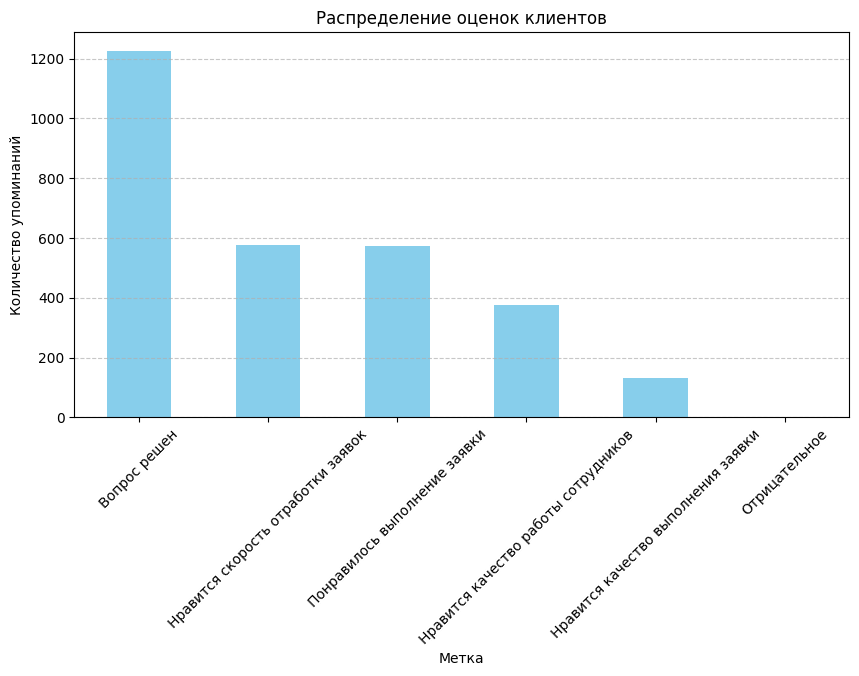

In [ ]:

import matplotlib.pyplot as plt

label_counts.plot(kind='bar', color='skyblue', figsize=(10, 5))
plt.title("Распределение оценок клиентов")
plt.ylabel("Количество упоминаний")
plt.xlabel("Метка")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [27]:
df.describe()

,annotation_id,annotator,id,lead_time,rating,Вопрос решен,Нравится качество выполнения заявки,Нравится качество работы сотрудников,Нравится скорость отработки заявок,Понравилось выполнение заявки,Негативное,Отрицательное
count,2372.000000,2372.0,2.372000e+03,2372.000000,2372.000000,2372.000000,2372.000000,2372.000000,2372.000000,2372.000000,2372.000000,2372.0
mean,706.737774,1.0,4.046167e+06,13.850452,4.954890,0.517285,0.054806,0.158516,0.242833,0.241990,0.002530,0.0
std,487.078887,0.0,1.651233e+05,63.121182,0.382103,0.499807,0.227649,0.365301,0.428885,0.428379,0.050241,0.0
min,1.000000,1.0,2.945792e+06,1.165000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,298.750000,1.0,3.912365e+06,2.573500,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,596.000000,1.0,3.953161e+06,4.048000,5.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,1109.250000,1.0,4.203986e+06,8.437500,5.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
max,1702.000000,1.0,4.237692e+06,2207.779000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


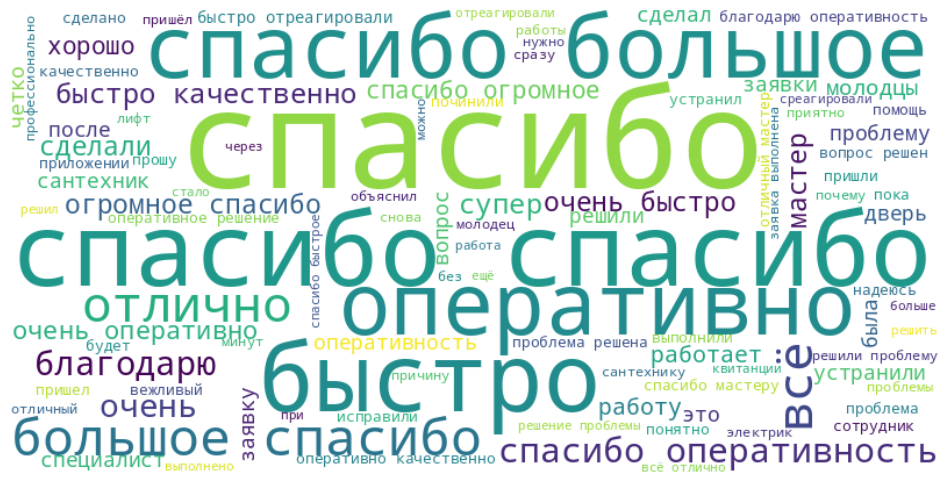

Самые частые слова: [('спасибо', 1336), ('быстро', 358), ('большое', 272), ('оперативно', 258), ('очень', 179), ('оперативность', 136), ('отлично', 109), ('благодарю', 109), ('всё', 107), ('мастер', 93), ('качественно', 89), ('огромное', 80), ('вопрос', 70), ('работу', 64), ('супер', 56), ('решили', 52), ('сделали', 51), ('проблему', 47), ('хорошо', 42), ('решение', 41)]


In [ ]:

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

RUSSIAN_STOP_WORDS = {
    'и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то',
    'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за',
    'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще',
    'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли',
    'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь',
    'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей',
    'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя'
}

STOP_WORDS = ENGLISH_STOP_WORDS.union(RUSSIAN_STOP_WORDS)

def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r'[^а-яА-ЯёЁa-zA-Z\s]', '', text)
    text = text.lower()
    words = text.split()
    words = [word for word in words if word not in STOP_WORDS and len(word) > 2]
    return ' '.join(words)

all_comments = ' '.join(df['comment'].astype(str).apply(preprocess_text))

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
    max_words=100,
    stopwords=STOP_WORDS,  # передаем стоп-слова напрямую в WordCloud
    contour_width=3,
    contour_color='steelblue'
).generate(all_comments)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

word_freq = Counter(all_comments.split())
print("Самые частые слова:", word_freq.most_common(20))

In [ ]:

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

target_columns = [
    'Нравится скорость отработки заявок',
    'Нравится качество выполнения заявки',
    'Нравится качество работы сотрудников',
    'Понравилось выполнение заявки',
    'Вопрос решен',
    'Отрицательное'
]

df['comment'] = df['comment'].fillna("")
df[target_columns] = df[target_columns].fillna(0).astype(int)

Стратифицированное разбиение
mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Получаем один разбиение (train/val)
for train_index, val_index in mskf.split(df['comment'], df[target_columns]):
    X_train, X_val = df['comment'].iloc[train_index], df['comment'].iloc[val_index]
    y_train, y_val = df[target_columns].iloc[train_index], df[target_columns].iloc[val_index]
    break  # используем только первое разбиение


In [ ]:

import pandas as pd
from sklearn.metrics import roc_auc_score
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, BertTokenizer, BertModel
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torch import nn
from tqdm import tqdm



# Конфигурация
MODEL_NAME = "DeepPavlov/rubert-base-cased"
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Токенизатор BERT
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)


#Класс для датасета
class CommentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts.tolist()
        self.labels = labels.values
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        encoding = self.tokenizer(
            self.texts[item],
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(self.labels[item], dtype=torch.float)
        }


train_dataset = CommentDataset(X_train, y_train, tokenizer, MAX_LEN)
val_dataset = CommentDataset(X_val, y_val, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)


#Модель на основе BERT
class BERTClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super(BERTClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.pooler_output
        return torch.sigmoid(self.classifier(self.dropout(pooled)))


model = BERTClassifier(MODEL_NAME, num_labels=len(target_columns)).to(DEVICE)
optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.BCELoss()


#Функции обучения и валидации
def train_epoch(model, data_loader, loss_fn, optimizer):
    model.train()
    total_loss = 0
    for batch in tqdm(data_loader):
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)

        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, labels)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()
    return total_loss / len(data_loader)


def eval_model(model, data_loader):
    model.eval()
    preds = []
    trues = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels = batch['labels'].cpu().numpy()
            outputs = model(input_ids, attention_mask).cpu().numpy()
            preds.append(outputs)
            trues.append(labels)
    return np.vstack(trues), np.vstack(preds)


#Обучение
for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    train_loss = train_epoch(model, train_loader, loss_fn, optimizer)
    print(f"Train Loss: {train_loss:.4f}")

#Валидация
y_true, y_pred = eval_model(model, val_loader)
# Применяем порог 0.5
y_pred_binary = (y_pred > 0.5).astype(int)

# Гарантируем хотя бы одну метку
for i in range(y_pred_binary.shape[0]):
    if y_pred_binary[i].sum() == 0:
        # Назначим метку с максимальной вероятностью
        max_idx = y_pred[i].argmax()
        y_pred_binary[i, max_idx] = 1

print("\nClassification Report:")
print(classification_report(y_true, y_pred_binary, target_names=target_columns, zero_division=0))

print("\nROC-AUC по классам:")
for i, col in enumerate(target_columns):
    score = roc_auc_score(y_true[:, i], y_pred[:, i])
    print(f"{col}: {score:.4f}")

# Средний ROC-AUC (macro)
macro_auc = roc_auc_score(y_true, y_pred, average='macro')
print(f"\nMacro ROC-AUC: {macro_auc:.4f}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Epoch 1/3



 22%|██▏       | 26/119 [10:50<43:15, 27.91s/it]

In [ ]:

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score

#ROC-кривые для каждого класса
plt.figure(figsize=(12, 8))

# Словари для хранения метрик
fpr = dict()
tpr = dict()
roc_auc = dict()

# Рассчитываем ROC для каждого класса
for i, category in enumerate(target_columns):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'{category} (AUC = {roc_auc[i]:.2f})')

# Добавляем случайный классификатор
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multi-Label Classification')
plt.legend(loc="lower right", fontsize=9)
plt.grid(True)
plt.show()

# Расчет и вывод метрик
# Средний ROC-AUC
macro_roc_auc = roc_auc_score(y_true, y_pred, average='macro')
micro_roc_auc = roc_auc_score(y_true, y_pred, average='micro')
print(f'\nMicro ROC-AUC: {micro_roc_auc:.4f}')
print(f'Macro ROC-AUC: {macro_roc_auc:.4f}')

# Бинарные предсказания с гарантией хотя бы одной метки
y_pred_binary = (y_pred > 0.5).astype(int)
for i in range(y_pred_binary.shape[0]):
    if y_pred_binary[i].sum() == 0:
        y_pred_binary[i, y_pred[i].argmax()] = 1

# Основные метрики
accuracy = accuracy_score(y_true, y_pred_binary)
precision = precision_score(y_true, y_pred_binary, average='macro', zero_division=0)
recall = recall_score(y_true, y_pred_binary, average='macro', zero_division=0)
f1 = f1_score(y_true, y_pred_binary, average='macro', zero_division=0)

print(f'\nAccuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')

In [ ]:

import pandas as pd
from sklearn.metrics import roc_auc_score
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torch import nn
from tqdm import tqdm

#Конфигурация
MODEL_NAME = "cointegrated/rubert-tiny2"
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Токенизатор 
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Датасет
class CommentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts.tolist()
        self.labels = labels.values
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        encoding = self.tokenizer(
            self.texts[item],
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(self.labels[item], dtype=torch.float)
        }

train_dataset = CommentDataset(X_train, y_train, tokenizer, MAX_LEN)
val_dataset = CommentDataset(X_val, y_val, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# Модель
class BERTClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super(BERTClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        # У моделей типа tiny2 нет pooler_output, берём CLS токен напрямую
        cls_token = outputs.last_hidden_state[:, 0, :]
        return torch.sigmoid(self.classifier(self.dropout(cls_token)))

model = BERTClassifier(MODEL_NAME, num_labels=len(target_columns)).to(DEVICE)
optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.BCELoss()

# Функции обучения и оценки
def train_epoch(model, data_loader, loss_fn, optimizer):
    model.train()
    total_loss = 0
    for batch in tqdm(data_loader):
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)

        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, labels)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()
    return total_loss / len(data_loader)

def eval_model(model, data_loader):
    model.eval()
    preds = []
    trues = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels = batch['labels'].cpu().numpy()
            outputs = model(input_ids, attention_mask).cpu().numpy()
            preds.append(outputs)
            trues.append(labels)
    return np.vstack(trues), np.vstack(preds)

# Обучение 
for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    train_loss = train_epoch(model, train_loader, loss_fn, optimizer)
    print(f"Train Loss: {train_loss:.4f}")

# Валидация
y_true, y_pred = eval_model(model, val_loader)
y_pred_binary = (y_pred > 0.5).astype(int)

# Назначаем хотя бы одну метку
for i in range(y_pred_binary.shape[0]):
    if y_pred_binary[i].sum() == 0:
        y_pred_binary[i, y_pred[i].argmax()] = 1

print("\nClassification Report:")
print(classification_report(y_true, y_pred_binary, target_names=target_columns, zero_division=0))

print("\nROC-AUC по классам:")
for i, col in enumerate(target_columns):
    score = roc_auc_score(y_true[:, i], y_pred[:, i])
    print(f"{col}: {score:.4f}")

macro_auc = roc_auc_score(y_true, y_pred, average='macro')
print(f"\nMacro ROC-AUC: {macro_auc:.4f}")

In [ ]:

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score

# ROC-кривые для каждого класса
plt.figure(figsize=(12, 8))

# Словари для хранения метрик
fpr = dict()
tpr = dict()
roc_auc = dict()

# Рассчитываем ROC для каждого класса
for i, category in enumerate(target_columns):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'{category} (AUC = {roc_auc[i]:.2f})')

# Добавляем случайный классификатор
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multi-Label Classification')
plt.legend(loc="lower right", fontsize=9)
plt.grid(True)
plt.show()

# Расчет и вывод метрик
# Средний ROC-AUC
macro_roc_auc = roc_auc_score(y_true, y_pred, average='macro')
micro_roc_auc = roc_auc_score(y_true, y_pred, average='micro')
print(f'\nMicro ROC-AUC: {micro_roc_auc:.4f}')
print(f'Macro ROC-AUC: {macro_roc_auc:.4f}')

# Бинарные предсказания с гарантией хотя бы одной метки
y_pred_binary = (y_pred > 0.5).astype(int)
for i in range(y_pred_binary.shape[0]):
    if y_pred_binary[i].sum() == 0:
        y_pred_binary[i, y_pred[i].argmax()] = 1

# Основные метрики
accuracy = accuracy_score(y_true, y_pred_binary)
precision = precision_score(y_true, y_pred_binary, average='macro', zero_division=0)
recall = recall_score(y_true, y_pred_binary, average='macro', zero_division=0)
f1 = f1_score(y_true, y_pred_binary, average='macro', zero_division=0)

print(f'\nAccuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')

In [ ]:

import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, classification_report
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from torch.optim import AdamW
from torch import nn
from tqdm import tqdm



# Конфигурация
MODEL_NAME = "sberbank-ai/ruBert-large"
MAX_LEN = 128
BATCH_SIZE = 8
EPOCHS = 3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class CommentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts.tolist()
        self.labels = labels.values
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        encoding = self.tokenizer(
            self.texts[item],
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(self.labels[item], dtype=torch.float)
        }

train_dataset = CommentDataset(X_train, y_train, tokenizer, MAX_LEN)
val_dataset = CommentDataset(X_val, y_val, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# Модель
class BERTClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super(BERTClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_token = outputs.last_hidden_state[:, 0, :]  # [CLS] токен
        return torch.sigmoid(self.classifier(self.dropout(cls_token)))

model = BERTClassifier(MODEL_NAME, num_labels=len(target_columns)).to(DEVICE)
optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.BCELoss()

# Функции обучения и оценки
def train_epoch(model, data_loader, loss_fn, optimizer):
    model.train()
    total_loss = 0
    for batch in tqdm(data_loader):
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)

        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, labels)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()
    return total_loss / len(data_loader)

def eval_model(model, data_loader):
    model.eval()
    preds = []
    trues = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels = batch['labels'].cpu().numpy()
            outputs = model(input_ids, attention_mask).cpu().numpy()
            preds.append(outputs)
            trues.append(labels)
    return np.vstack(trues), np.vstack(preds)

# Обучение
for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    train_loss = train_epoch(model, train_loader, loss_fn, optimizer)
    print(f"Train Loss: {train_loss:.4f}")

# Валидация
y_true, y_pred = eval_model(model, val_loader)
# Применяем порог 0.5
y_pred_binary = (y_pred > 0.5).astype(int)

for i in range(y_pred_binary.shape[0]):
    if y_pred_binary[i].sum() == 0:
        y_pred_binary[i, y_pred[i].argmax()] = 1

print("\nClassification Report:")
print(classification_report(y_true, y_pred_binary, target_names=target_columns, zero_division=0))

print("\nROC-AUC по классам:")
for i, col in enumerate(target_columns):
    score = roc_auc_score(y_true[:, i], y_pred[:, i])
    print(f"{col}: {score:.4f}")

macro_auc = roc_auc_score(y_true, y_pred, average='macro')
print(f"\nMacro ROC-AUC: {macro_auc:.4f}")


In [ ]:

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score

# ROC-кривые для каждого класса
plt.figure(figsize=(12, 8))

# Словари для хранения метрик
fpr = dict()
tpr = dict()
roc_auc = dict()

# Рассчитываем ROC для каждого класса
for i, category in enumerate(target_columns):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'{category} (AUC = {roc_auc[i]:.2f})')

# Добавляем случайный классификатор
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multi-Label Classification')
plt.legend(loc="lower right", fontsize=9)
plt.grid(True)
plt.show()

# Расчет и вывод метрик
# Средний ROC-AUC
macro_roc_auc = roc_auc_score(y_true, y_pred, average='macro')
micro_roc_auc = roc_auc_score(y_true, y_pred, average='micro')
print(f'\nMicro ROC-AUC: {micro_roc_auc:.4f}')
print(f'Macro ROC-AUC: {macro_roc_auc:.4f}')

# Бинарные предсказания с гарантией хотя бы одной метки
y_pred_binary = (y_pred > 0.5).astype(int)
for i in range(y_pred_binary.shape[0]):
    if y_pred_binary[i].sum() == 0:
        y_pred_binary[i, y_pred[i].argmax()] = 1

# Основные метрики
accuracy = accuracy_score(y_true, y_pred_binary)
precision = precision_score(y_true, y_pred_binary, average='macro', zero_division=0)
recall = recall_score(y_true, y_pred_binary, average='macro', zero_division=0)
f1 = f1_score(y_true, y_pred_binary, average='macro', zero_division=0)

print(f'\nAccuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')

In [ ]:
new_comments = ["Очень доволен скоростью", "Проблема не решена", "Спасибо за помощь", "Быстро", "Ничего не сделали, ужасное отношение", "Выполнили отлично, оперативно, качественно"]
df_test = pd.DataFrame({'comment': new_comments})

In [ ]:
test_dataset = CommentDataset(df_test['comment'],
                              pd.DataFrame([[0]*len(target_columns)]*len(df_test), columns=target_columns),
                              tokenizer,
                              MAX_LEN)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [ ]:
model.eval()
all_preds = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        outputs = model(input_ids, attention_mask).cpu().numpy()
        all_preds.append(outputs)

# Объединяем все батчи
pred_probs = np.vstack(all_preds)

# Бинаризуем при необходимости (порог 0.5)
pred_labels = (pred_probs > 0.5).astype(int)

In [ ]:
# В виде DataFrame
pred_df = pd.DataFrame(pred_labels, columns=target_columns)
result_df = pd.concat([df_test['comment'].reset_index(drop=True), pred_df], axis=1)

result_df
